In [3]:
# load the dataset from kaggle

import kagglehub

# Download latest version
path = kagglehub.dataset_download("bhavikjikadara/dog-and-cat-classification-dataset")

print("Path to dataset files:", path)

100%|██████████| 775M/775M [00:22<00:00, 35.5MB/s] 

Extracting files...


Path to dataset files: C:\Users\Horo\.cache\kagglehub\datasets\bhavikjikadara\dog-and-cat-classification-dataset\versions\1


In [4]:
from tensorflow import keras
import numpy as np
import pandas as pd
from PIL import Image
import os

In [5]:
def load_images_from_folder(folder, label, img_size=(64,64), max_images=None):
    images, labels = [], []
    for i, filename in enumerate(os.listdir(folder)):
        if filename.endswith('.jpg'):
            try:
                img = Image.open(os.path.join(folder, filename)).convert('RGB')
                img = img.resize(img_size)
                images.append(np.array(img))
                labels.append(label)
            except:
                continue
        if max_images and i >= max_images-1:
            break
    return images, labels

cat_images, cat_labels = load_images_from_folder(f'{path}/PetImages/Cat', 0)
dog_images, dog_labels = load_images_from_folder(f'{path}/PetImages/Dog', 1)

X = np.array(cat_images + dog_images)
y = np.array(cat_labels + dog_labels)

d:\Alex\softuri\anaconda3\Lib\site-packages\PIL\TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))


In [7]:
print(X.shape)
print(y.shape)

(24998, 64, 64, 3)
(24998,)


[33 39 46]


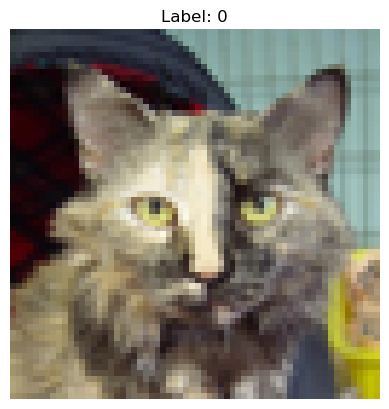

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(X[2])
plt.title(f"Label: {y[2]}")
plt.axis('off')
plt.show()

In [23]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical


#Normalize images from [0,255] to [0, 1]
X = X.astype('float32') / 255.0 

num_filters = 32
filter_size = 3
pool_size = 2

#Build the model
# model = Sequential([
#     Conv2D(num_filters, filter_size, input_shape = (64, 64, 3)),
#     MaxPooling2D(pool_size=pool_size),
#     Flatten(),
#     Dense(2,activation='softmax'),
# ])

model = Sequential([
    Conv2D(32, 3, activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(2),
    Conv2D(64, 3, activation='relu'),
    MaxPooling2D(2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(
    'adam',
    loss ='binary_crossentropy',
    metrics = ['accuracy']
)

model.fit(
    X,
    y,
    epochs = 15,
    batch_size = 32,
    validation_split = 0.2
)

model.save_weights('./weights/cat_vs_dog_5epochs.weights.h5')

Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 34ms/step - accuracy: 0.6250 - loss: 0.6645 - val_accuracy: 0.0000e+00 - val_loss: 0.9547
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.6250 - loss: 0.6627 - val_accuracy: 0.0000e+00 - val_loss: 1.0520
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.6250 - loss: 0.6623 - val_accuracy: 0.0000e+00 - val_loss: 1.0424
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.6250 - loss: 0.6623 - val_accuracy: 0.0000e+00 - val_loss: 0.9849
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.6250 - loss: 0.6619 - val_accuracy: 0.0000e+00 - val_loss: 0.9464
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.6250 - loss: 0.6620 - val_accuracy: 0.0000e+00 - val_loss: 0.9847
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.6250 - loss: 0.6619 - val_accuracy: 0.0000e+00 - val_loss: 0.9565
Epoch 8/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 24s 39ms/step - accura